In [149]:
# Import library yang diperlukan
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.feature import hog
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

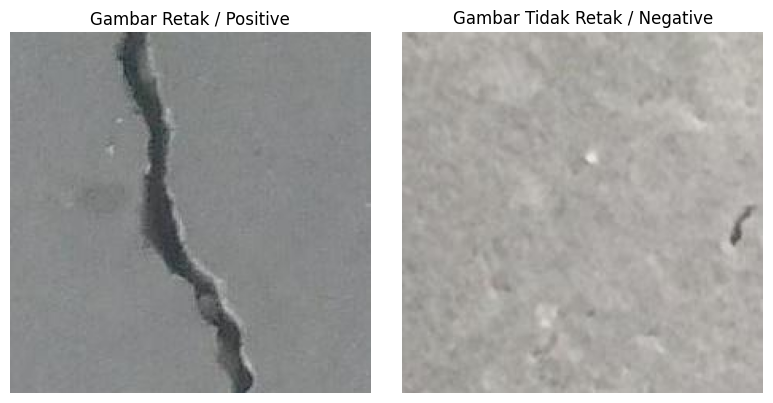

In [150]:
# dataset yang digunakan adalah citra permukaan retak dan tidak retak 
# dataset memiliki dua kelas yaitu kelas positive untuk citra permukaan retak dan kelas negative untuk citra permukaan tidak retak
# dataset yang digunakan berjumlah 500 setiap kelasnya sehingga total kesuluruhan dataset adalah 1000 citra

fig, axes = plt.subplots(1, 2, figsize=(8, 4)) 
# menampilkan dataset citra
# citra retak/positive
img1 = Image.open('./dataset/Positive/00001.jpg')
axes[0].imshow(img1)
axes[0].set_title('Gambar Retak / Positive')
axes[0].axis('off')

# citra tidak retak/negative
img2 = Image.open('./dataset/Negative/00001.jpg')
axes[1].imshow(img2)
axes[1].set_title('Gambar Tidak Retak / Negative')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [151]:
# fungsi untuk membaca dataset dan mengubah citra rgb menjadi grayscale
def load_image(path):
    image = io.imread(path) # membaca path yang menyimpan dataset citra
    image = color.rgb2gray(image) # mengubah citra yang tersimpan dalam image ke dalam grayscale
    return image

In [152]:
# fungsi untuk resize ukuran citra 
def resize_image(image):
    resize_img = resize(image, (128, 128)) # citra diresize ke 128x128 agar ukuran bisa konsisten sebelum dilakukan ekstraksi fitur
    return resize_img

In [153]:
# HOG (Histogram of Oriented Gradients) adalah teknik ekstraksi fitur berdasarkan arah garis dan tepi (edge) yang ada dalam gambar
# HOG melihat bentuk dan arah garis di gambar sehingga teknik ini efektif mendeteksi pola seperti retakan pada jalan,
# karena retakan memiliki arah, tekstur, dan tepi yang khas

# fungsi untuk ektraksi fitur citra menggunakan hog
def extract_hog(image):
    features, hog_img = hog(image,
                            orientations=9, # jumlah arah sudut gradien
                            cells_per_block=(2, 2), # blok tempat cell dilakukan
                            pixels_per_cell=(8, 8), # ukuran tiap cell dalam piksel
                            visualize=True) 
    return features, hog_img

In [154]:
# fungsi untuk menampilan citra di setiap proses 
def visualize(resized_img, hog_img, filename, cls):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(resized_img, cmap='gray') # menampilkan citra yang diresize
    axs[0].set_title(f"{cls} - Resize")
    axs[0].axis('off')

    axs[1].imshow(hog_img, cmap='gray') # menampilkan citra setelah ekstraksi fitur hog
    axs[1].set_title("HOG")
    axs[1].axis('off')

    plt.suptitle(f"Gambar: {filename}") # menampilkan nama file citra
    plt.tight_layout()
    plt.show()

In [155]:
# fungsi untuk memproses seluruh dataset citra 
def process_dataset(dataset_path, classes, max_show=2):
    data = []
    labels = []

    for label_idx, cls in enumerate(classes):
        folder_path = os.path.join(dataset_path, cls)
        shown = 0
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            image = load_image(img_path) # load dataset citra
            resized = resize_image(image) # resize ukuran citra 
            features, hog_image = extract_hog(resized) # ekstraksi fitur citra

            data.append(features) # memasukan nilai fitur ke dalam list data
            labels.append(label_idx) # memasukan index label ke dalam list label

            if shown < max_show:
                visualize(resized, hog_image, filename, cls) # menampilkan citra 
                shown += 1

    return np.array(data), np.array(labels)

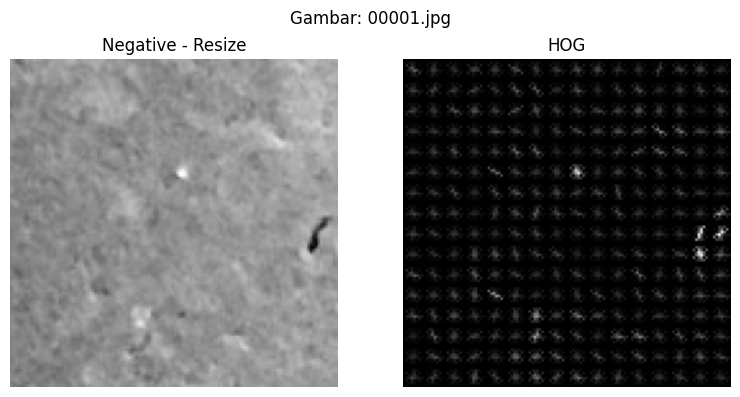

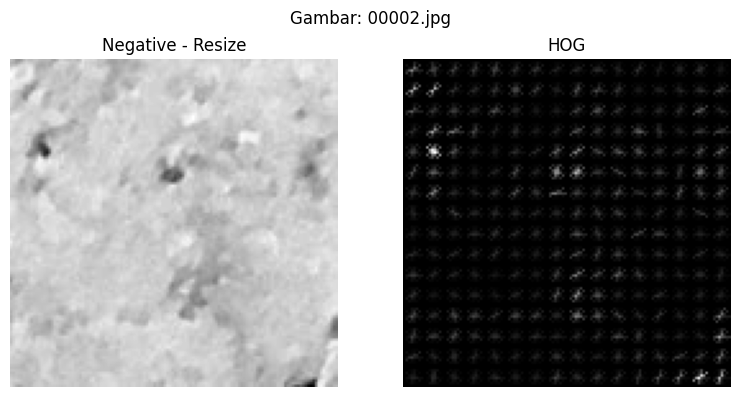

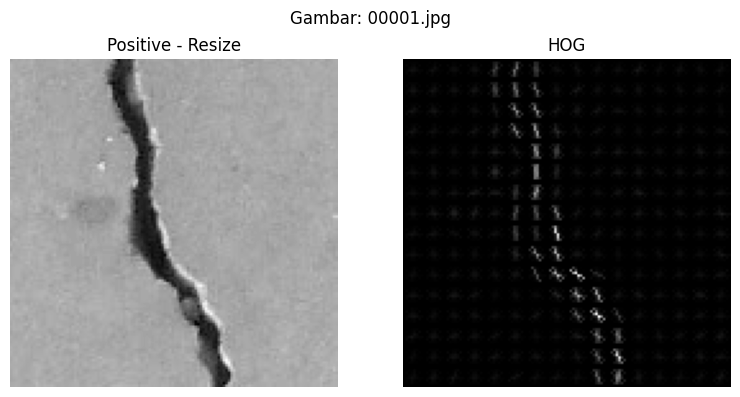

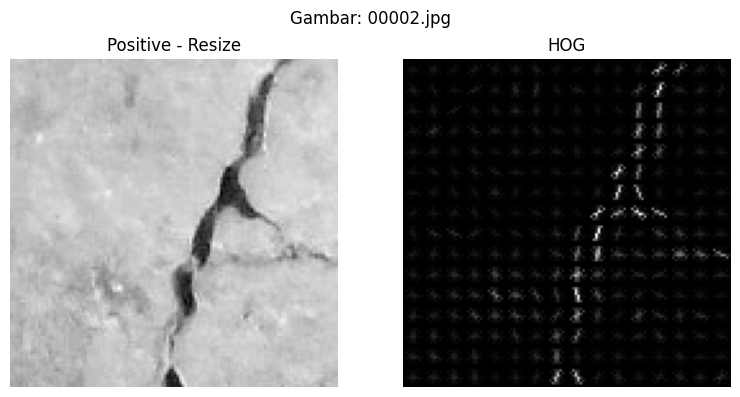

In [156]:
dataset_path = "dataset" # nama folder dataset
classes = ['Negative', 'Positive'] # nama kelas dataset (positive untuk citra retak dan negative untuk citra tidak retak)

X, y = process_dataset(dataset_path, classes) # mengubah seluruh data citra dan menyimpan ke dalam variabel X untuk citra dan variabel y untuk label citra

In [157]:
# menampilkan jumlah data dan jumlah fitur citra
print(f"Jumlah data: {len(X)}")
print(f"Jumlah fitur per gambar: {len(X[0])}")

Jumlah data: 1000
Jumlah fitur per gambar: 8100


In [158]:
# membagi data ke dalam subset train dan test dengan ukuran test sebanyak 0.2 dari jumlah data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [159]:
# menampilkan jumlah data train dan test
print(f"Jumlah data train: {len(X_train)}")
print(f"Jumlah data test: {len(X_test)}")

Jumlah data train: 800
Jumlah data test: 200


In [160]:
# membuat model SVM 
# model SVM digunakan karena model ini bagus untuk data berdimensi tinggi, seperti HOG yang menghasilkan banyak fitur
model = SVC(kernel='linear', random_state=42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [161]:
# menguji data test 
y_pred = model.predict(X_test)

In [162]:
# menampilkan hasil klasifikasi dengan metrik precision, recall, dan f1 score
# berdasarkan hasil uji, didapatkan
# nilai precision positive 0.97 yang berarti dari semua prediksi positive, 97% benar
# nilai recall positive 0.93 yang berarti dari semua data positive sebenarnya, 93% berhasil ditemukan
# nilai precision negative 0.93 yang berarti dari semua prediksi negative, 93% benar
# nilai recall negative 0.97 yang berarti dari semua data negative sebenarnya, 97% berhasil ditemukan
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

    Negative       0.93      0.97      0.95        96
    Positive       0.97      0.93      0.95       104

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



In [163]:
# menampilkan nilai akurasi keseluruhan 
# nilai akurasi 0.95 menunjukkan bahwa 95% dari total prediksi pada data test berhasil diklasifikasi dengan benar
acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

Accuracy:  0.95


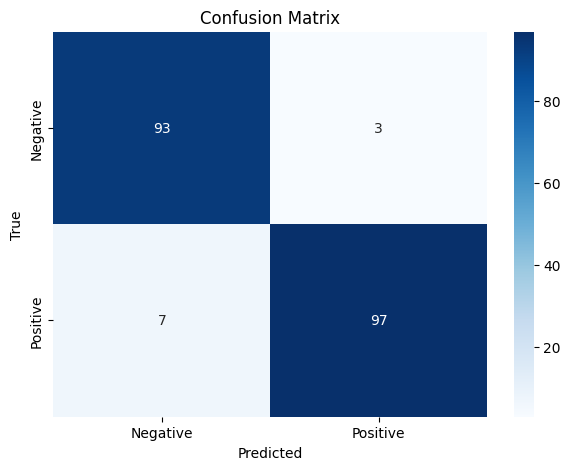

In [164]:
# visualisasi dengan confusion matrix
# True Negative: terdapat 93 citra yang diprediksi tidak retak/negative saat citra memang negative 
# True Positive: terdapat 97 citra yang diprediksi retak/positive saat citra memang positive
# False Positive: terdapat 7 citra yang diprediksi tidak retak/negative saat citra positive
# False Negative: terdapat 3 citra yang diprediksi retak/positive saat citra negative

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(classes), yticklabels=np.unique(classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

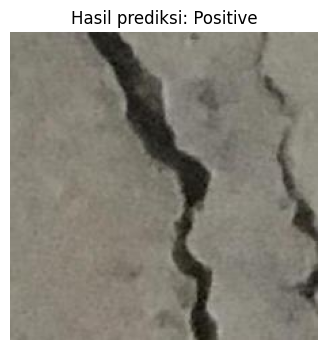

In [165]:
# contoh klasifikasi
path_image = './dataset/Positive/00100.jpg'

image = load_image(path_image)
resized = resize_image(image)                      
features, hog_image = extract_hog(resized)         

features = np.array([features])                   
hasil_pred = model.predict(features) 

if hasil_pred == [0]:
    hasil_pred = "Negative"
elif hasil_pred == [1]:
    hasil_pred = "Positive"

img = Image.open(path_image)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.title(f"Hasil prediksi: {hasil_pred}")
plt.axis('off')
plt.show()